# Analisando Artigos sobre COVID-19

Neste desafio, vamos continuar com o tema da pandemia de COVID e focar na análise de artigos científicos sobre o assunto. Existe o [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) com mais de 7000 artigos (à data de escrita) sobre COVID, disponível com metadados e resumos (e para cerca de metade deles também está disponível o texto completo).

Um exemplo completo de análise deste conjunto de dados utilizando o serviço cognitivo [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) é descrito [neste artigo de blog](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Vamos discutir uma versão simplificada desta análise.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Obter os Dados

Primeiro, precisamos obter os metadados dos artigos CORD com os quais iremos trabalhar.

**NOTA**: Não fornecemos uma cópia do conjunto de dados como parte deste repositório. Pode ser necessário primeiro descarregar o ficheiro [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) a partir [deste conjunto de dados no Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Pode ser necessário registar-se no Kaggle. Também pode descarregar o conjunto de dados sem registo [a partir daqui](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), mas este incluirá todos os textos completos, além do ficheiro de metadados.

Tentaremos obter os dados diretamente da fonte online; no entanto, se isso falhar, será necessário descarregar os dados conforme descrito acima. Além disso, faz sentido descarregar os dados se planeia experimentá-los mais tarde, para poupar tempo de espera.

> **NOTA** que o conjunto de dados é bastante grande, com cerca de 1 Gb de tamanho, e a seguinte linha de código pode demorar bastante a ser concluída! (~5 minutos)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Agora vamos converter a coluna de data de publicação para `datetime` e criar o histograma para ver o intervalo de datas de publicação.


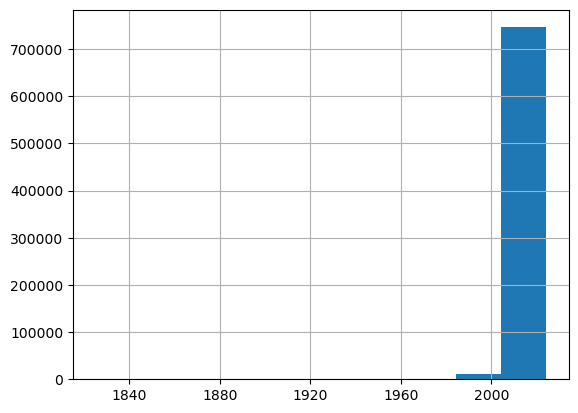

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Extração de Dados Estruturados

Vamos ver que tipo de informação podemos extrair facilmente de resumos. Uma coisa que pode ser do nosso interesse é identificar quais estratégias de tratamento existem e como evoluíram ao longo do tempo. Para começar, podemos compilar manualmente a lista de possíveis medicamentos usados para tratar a COVID, bem como a lista de diagnósticos. Em seguida, analisamos essas listas e procuramos os termos correspondentes nos resumos dos artigos.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Adicionámos várias colunas ao nosso dataframe que contêm o número de vezes que um determinado medicamento/diagnóstico aparece no resumo.

> **Nota** que adicionamos um espaço no início da palavra ao procurar por uma substring. Se não fizermos isso, podemos obter resultados errados, porque *cloroquina* também seria encontrada dentro da substring *hidroxicloroquina*. Além disso, forçamos a conversão da coluna de resumos para `str` para evitar um erro - experimente remover `str` e veja o que acontece.

Para facilitar o trabalho com os dados, podemos extrair o sub-quadro contendo apenas as contagens de medicamentos e calcular o número acumulado de ocorrências. Isto permite-nos identificar o medicamento mais popular:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

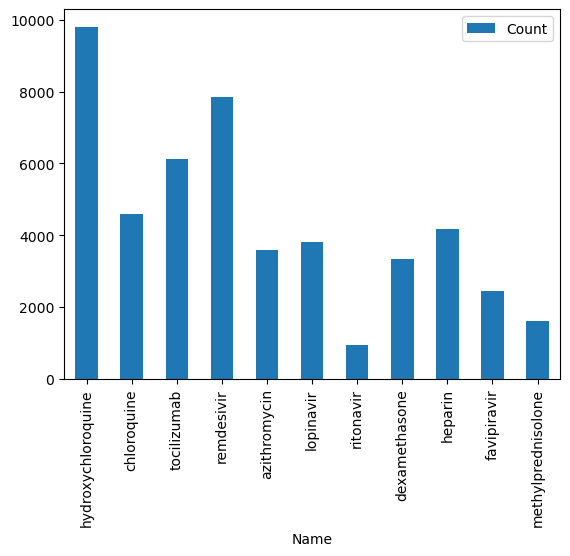

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Procurar Tendências na Estratégia de Tratamento

No exemplo acima, somámos todos os valores, mas também podemos fazer o mesmo numa base mensal:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

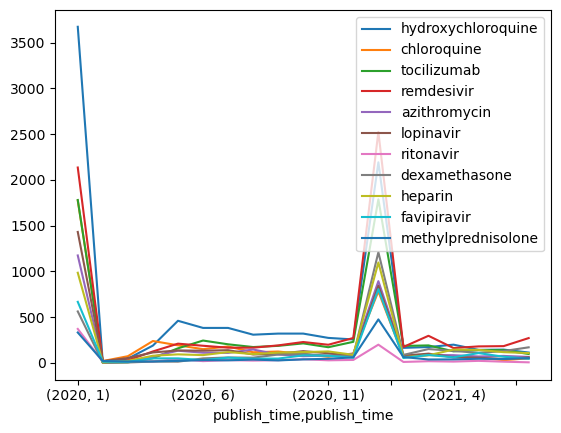

In [152]:
dfmt.plot()
plt.show()

Uma observação interessante é que temos grandes picos em dois momentos: janeiro de 2020 e janeiro de 2021. Isto deve-se ao facto de alguns artigos não terem uma data de publicação claramente especificada, sendo atribuídos a janeiro do respetivo ano.

Para tornar os dados mais compreensíveis, vamos visualizar apenas alguns medicamentos. Também iremos "apagar" os dados de janeiro e substituí-los por um valor médio, de forma a criar um gráfico mais agradável:


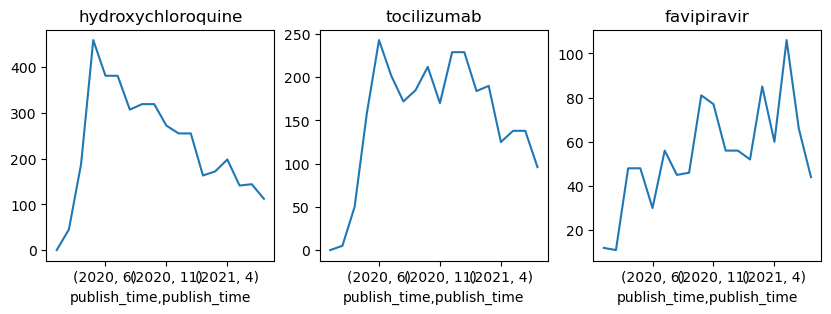

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

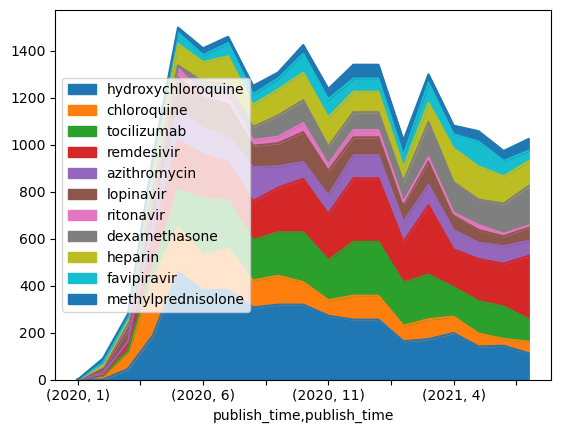

In [154]:
dfmt.plot.area()
plt.show()

Ainda mais, podemos calcular a popularidade relativa em percentagens:


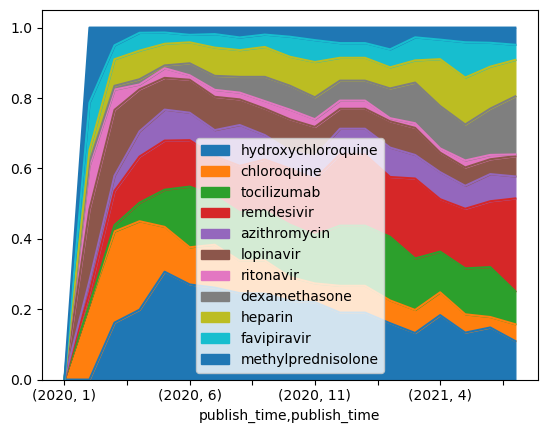

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Correspondência entre Diagnóstico e Medicamento

Uma das relações mais interessantes que podemos explorar é como diferentes diagnósticos são tratados com diferentes medicamentos. Para visualizar isso, precisamos calcular um **mapa de frequência de coocorrência**, que mostrará quantas vezes dois termos são mencionados no mesmo artigo.

Esse mapa é, essencialmente, uma matriz 2D, que é melhor representada por um **array numpy**. Vamos calcular este mapa percorrendo todos os resumos e marcando as entidades que aparecem neles:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Uma das formas de visualizar esta matriz é desenhar um **mapa de calor**:


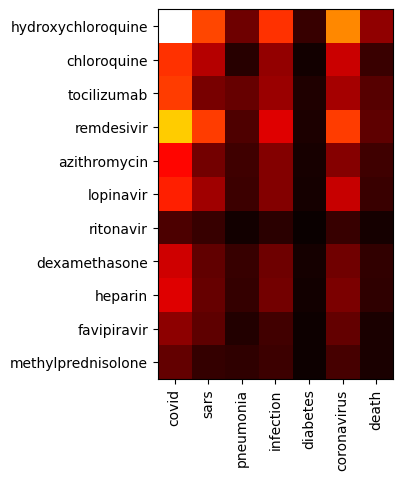

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

No entanto, uma visualização ainda melhor pode ser feita utilizando o chamado diagrama **Sankey**! O `matplotlib` não possui suporte nativo para este tipo de diagrama, por isso teremos de usar o [Plotly](https://plotly.com/python/) conforme descrito [neste tutorial](https://plotly.com/python/sankey-diagram/).

Para criar um diagrama Sankey com Plotly, precisamos construir as seguintes listas:
* Lista `all_nodes` com todos os nós do gráfico, que incluirá tanto os medicamentos como os diagnósticos
* Lista de índices de origem e destino - essas listas indicarão quais nós vão para a parte esquerda e quais vão para a parte direita do diagrama
* Lista de todos os links, cada link consistindo de:
   - Índice de origem na matriz `all_nodes`
   - Índice de destino
   - Valor que indica a força do link. Este é exatamente o valor da nossa matriz de co-ocorrência.
   - Opcionalmente, a cor do link. Faremos uma opção para destacar alguns dos termos para maior clareza.

O código genérico para desenhar o diagrama Sankey está estruturado como uma função separada chamada `sankey`, que recebe duas listas (categorias de origem e destino) e a matriz de co-ocorrência. Também nos permite especificar um limite e omitir todos os links que sejam mais fracos do que esse limite - isso torna o diagrama um pouco menos complexo.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusão

Vimos que é possível utilizar métodos bastante simples para extrair informações de fontes de dados não estruturados, como texto. Neste exemplo, utilizámos a lista existente de medicamentos, mas seria muito mais poderoso recorrer a técnicas de processamento de linguagem natural (NLP) para realizar a extração de entidades a partir de texto. Neste [artigo de blog](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) descrevemos como usar serviços na nuvem para extração de entidades. Outra opção seria utilizar bibliotecas de NLP em Python, como [NLTK](https://www.nltk.org/) - uma abordagem para extrair informações de texto usando NLTK é descrita [aqui](https://www.nltk.org/book/ch07.html).


## Desafio

Continue a investigar os dados dos artigos sobre COVID ao longo das seguintes linhas:

1. Construa uma matriz de co-ocorrência de diferentes medicamentos e veja quais medicamentos frequentemente aparecem juntos (ou seja, mencionados num mesmo resumo). Pode modificar o código para construir a matriz de co-ocorrência de medicamentos e diagnósticos.
1. Visualize esta matriz utilizando um mapa de calor.
1. Como objetivo adicional, pode querer visualizar a co-ocorrência de medicamentos utilizando [diagrama de cordas](https://en.wikipedia.org/wiki/Chord_diagram). [Esta biblioteca](https://pypi.org/project/chord/) pode ajudá-lo a desenhar um diagrama de cordas.
1. Como outro objetivo adicional, tente extrair as dosagens de diferentes medicamentos (como **400mg** em *tomar 400mg de cloroquina diariamente*) utilizando expressões regulares e construa um dataframe que mostre diferentes dosagens para diferentes medicamentos. **Nota**: considere valores numéricos que estejam em proximidade textual ao nome do medicamento.



---

**Aviso Legal**:  
Este documento foi traduzido utilizando o serviço de tradução por IA [Co-op Translator](https://github.com/Azure/co-op-translator). Embora nos esforcemos para garantir a precisão, esteja ciente de que traduções automáticas podem conter erros ou imprecisões. O documento original no seu idioma nativo deve ser considerado a fonte autoritativa. Para informações críticas, recomenda-se a tradução profissional humana. Não nos responsabilizamos por quaisquer mal-entendidos ou interpretações incorretas resultantes do uso desta tradução.
